In [71]:
import os 
import pandas as pd 
import numpy as np 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.catboost

import optuna

In [72]:
mlflow.set_tracking_uri("file:nvidia_stock_prediction/mlruns")
# Definir el experimento (si no existe, se crea)
mlflow.set_experiment("baseline")

2025/03/13 12:51:52 INFO mlflow.tracking.fluent: Experiment with name 'baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/rospel/Desktop/prueba_tecnica_finaipro/nvidia_stock_prediction/notebooks/nvidia_stock_prediction/mlruns/268478086428075729', creation_time=1741888312885, experiment_id='268478086428075729', last_update_time=1741888312885, lifecycle_stage='active', name='baseline', tags={}>

In [73]:
ABT_path = os.path.join('..', 'data', 'ABTs', 'principal_ABT.csv')
ABT = pd.read_csv(ABT_path, index_col= 0)
ABT = ABT.astype('float64')

X = ABT.drop(columns=['target'])
y = ABT['target']

print(X.shape, y.shape)

(2738, 17) (2738,)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle= False)
print(f'Fecha inicio train: {X_train.index.min()}, Fecha final train {X_train.index.max()}')
print(f'Fecha inicio test: {X_test.index.min()}, Fecha final test {X_test.index.max()}')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Fecha inicio train: 2014-04-17, Fecha final train 2024-01-31
Fecha inicio test: 2024-02-01, Fecha final test 2025-03-06
(2464, 17) (2464,) (274, 17) (274,)


## Base LR model

In [75]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('model', LinearRegression())
])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('model', LinearRegression())])

In [76]:
#Train Metrics
y_pred_lr_train = pipeline_lr.predict(X_train)
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
rmse_lr_train = root_mean_squared_error(y_train, y_pred_lr_train)
r2_lr_train = r2_score(y_train, y_pred_lr_train)
print("lr - MAE:", mae_lr_train, "RMSE:", rmse_lr_train, "R2:", r2_lr_train)

lr - MAE: 0.24506579808861473 RMSE: 0.4805341798327068 R2: 0.9985405301340365


In [77]:
#Test Metrics
y_pred_lr = pipeline_lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("lr - MAE:", mae_lr, "RMSE:", rmse_lr, "R2:", r2_lr)

lr - MAE: 3.0363942499402485 RMSE: 4.126585301568755 R2: 0.9654813877716794


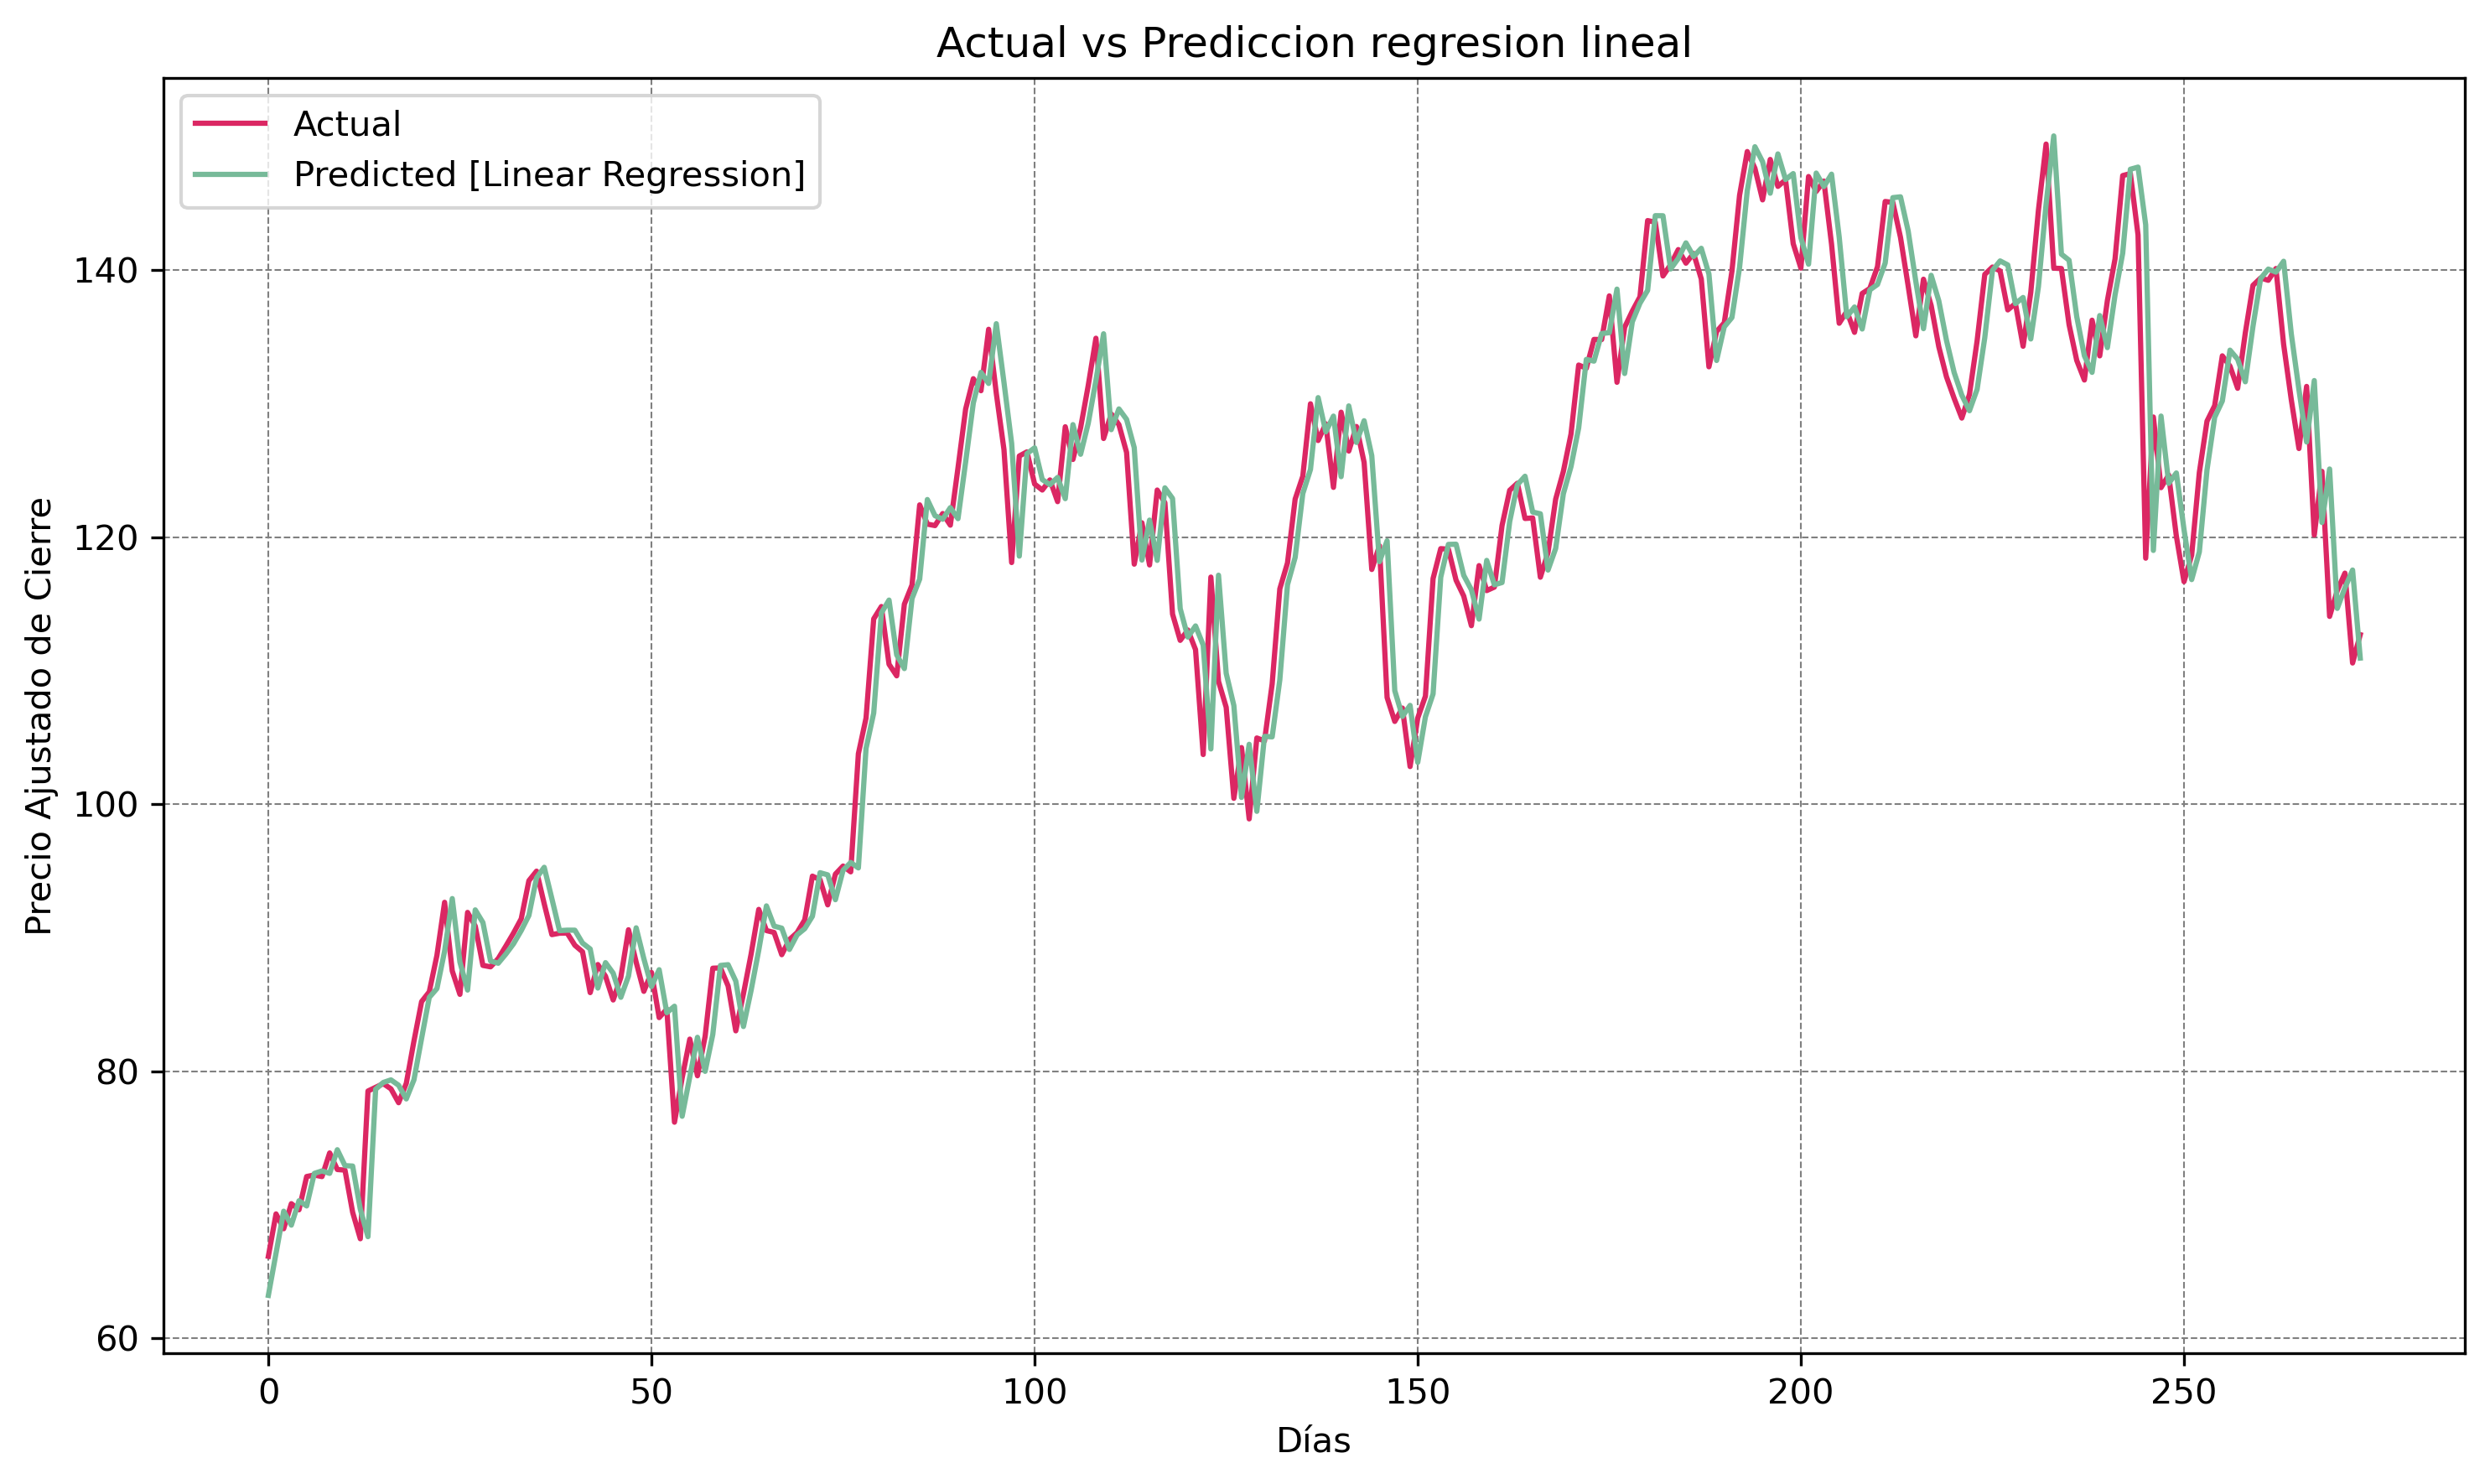

In [78]:
# Generamos un eje x ficticio con la cantidad de muestras de test
days = range(len(y_test))

plt.figure(figsize=(10, 6), dpi=300)

# Línea de valores reales (color #DB2763)
plt.plot(days, y_test, label='Actual', color='#DB2763')

# Línea de valores predichos (color #77BA99)
plt.plot(days, y_pred_lr, label='Predicted [Linear Regression]', color='#77BA99')

plt.xlabel('Días')
plt.ylabel('Precio Ajustado de Cierre')
plt.title('Actual vs Prediccion regresion lineal')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
with mlflow.start_run(run_name="Baseline_Linear_Regression"):
    mlflow.log_param("model_type", "Linear Regression")
    mlflow.log_metric("train_mae", mae_lr_train)
    mlflow.log_metric("train_rmse", rmse_lr_train)
    mlflow.log_metric("train_r2", r2_lr_train)
    mlflow.log_metric("test_mae", mae_lr)
    mlflow.log_metric("test_rmse", rmse_lr)
    mlflow.log_metric("test_r2", r2_lr)
    
    # Loguear el modelo, proporcionando un ejemplo de entrada
    mlflow.sklearn.log_model(lr_model, artifact_path="model", input_example=X_test.head(1))
    print("Modelo Baseline registrado en MLflow.")

Modelo Baseline registrado en MLflow.


## Boosting 

In [50]:
def objective_cat(trial, X, y):
    # Definir hiperparámetros a optimizar con rangos pensados para evitar sobreajuste
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': False
    }
    
    # Realizar un split cronológico: 80% de datos para entrenamiento, 20% para validación
    n_samples = len(X)
    split_index = int(n_samples * 0.8)
    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]
    X_val = X.iloc[split_index:]
    y_val = y.iloc[split_index:]
    
    # Crear Pools para entrenamiento y validación
    train_pool = Pool(data=X_train, label=y_train)
    val_pool = Pool(data=X_val, label=y_val)
    
    # Instanciar el modelo con los parámetros propuestos
    model = CatBoostRegressor(**params)
    
    # Entrenar con early stopping para evitar sobreajuste
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)
    
    # Predecir en el conjunto de validación
    y_pred = model.predict(val_pool)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Validation RMSE: {rmse_val:.4f}")
    
    # Registrar el experimento en MLflow (cada trial se registra como un run anidado)
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metric("rmse_val", rmse_val)
        mlflow.catboost.log_model(model, artifact_path="model", input_example=X_val.head(1))
    
    # Optuna busca minimizar el error de validación
    return rmse_val

In [54]:
study = optuna.create_study(direction="minimize", sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective_cat(trial, X_train, y_train), n_trials=50)

[I 2025-03-13 11:48:21,995] A new study created in memory with name: no-name-07ac5ed5-53a8-499d-b1ea-40875a6e1123


Validation RMSE: 12.0405


[I 2025-03-13 11:48:23,819] Trial 0 finished with value: 12.040469677654919 and parameters: {'iterations': 437, 'learning_rate': 0.07969454818643933, 'depth': 7, 'l2_leaf_reg': 6.387926357773329, 'border_count': 66}. Best is trial 0 with value: 12.040469677654919.


Validation RMSE: 23.3806


[I 2025-03-13 11:48:25,291] Trial 1 finished with value: 23.38064974625748 and parameters: {'iterations': 240, 'learning_rate': 0.0013066739238053278, 'depth': 8, 'l2_leaf_reg': 6.41003510568888, 'border_count': 190}. Best is trial 0 with value: 12.040469677654919.


Validation RMSE: 11.8693


[I 2025-03-13 11:48:26,524] Trial 2 finished with value: 11.869303077962394 and parameters: {'iterations': 118, 'learning_rate': 0.08706020878304854, 'depth': 7, 'l2_leaf_reg': 2.9110519961044856, 'border_count': 72}. Best is trial 2 with value: 11.869303077962394.


Validation RMSE: 17.5937


[I 2025-03-13 11:48:27,866] Trial 3 finished with value: 17.593650639372424 and parameters: {'iterations': 265, 'learning_rate': 0.004059611610484304, 'depth': 6, 'l2_leaf_reg': 4.887505167779042, 'border_count': 97}. Best is trial 2 with value: 11.869303077962394.


Validation RMSE: 16.4326


[I 2025-03-13 11:48:29,269] Trial 4 finished with value: 16.432575216834273 and parameters: {'iterations': 651, 'learning_rate': 0.0019010245319870357, 'depth': 4, 'l2_leaf_reg': 4.297256589643226, 'border_count': 134}. Best is trial 2 with value: 11.869303077962394.


Validation RMSE: 14.4179


[I 2025-03-13 11:48:30,791] Trial 5 finished with value: 14.417918503812594 and parameters: {'iterations': 807, 'learning_rate': 0.002508115686045234, 'depth': 6, 'l2_leaf_reg': 6.331731119758382, 'border_count': 42}. Best is trial 2 with value: 11.869303077962394.


Validation RMSE: 15.8585


[I 2025-03-13 11:48:32,178] Trial 6 finished with value: 15.858484427294478 and parameters: {'iterations': 647, 'learning_rate': 0.002193048555664369, 'depth': 3, 'l2_leaf_reg': 9.539969835279999, 'border_count': 248}. Best is trial 2 with value: 11.869303077962394.


Validation RMSE: 11.8351


[I 2025-03-13 11:48:33,605] Trial 7 finished with value: 11.835135557274215 and parameters: {'iterations': 828, 'learning_rate': 0.0040665633135147945, 'depth': 3, 'l2_leaf_reg': 7.158097238609412, 'border_count': 130}. Best is trial 7 with value: 11.835135557274215.


Validation RMSE: 13.9584


[I 2025-03-13 11:48:34,897] Trial 8 finished with value: 13.958353219832958 and parameters: {'iterations': 209, 'learning_rate': 0.009780337016659405, 'depth': 3, 'l2_leaf_reg': 9.18388361870904, 'border_count': 89}. Best is trial 7 with value: 11.835135557274215.


Validation RMSE: 12.8769


[I 2025-03-13 11:48:36,375] Trial 9 finished with value: 12.876916345963487 and parameters: {'iterations': 696, 'learning_rate': 0.004201672054372531, 'depth': 6, 'l2_leaf_reg': 5.920392514089517, 'border_count': 73}. Best is trial 7 with value: 11.835135557274215.


Validation RMSE: 10.1901


[I 2025-03-13 11:48:37,813] Trial 10 finished with value: 10.190060823291617 and parameters: {'iterations': 979, 'learning_rate': 0.025104410042504657, 'depth': 4, 'l2_leaf_reg': 1.1616568805333776, 'border_count': 175}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.3872


[I 2025-03-13 11:48:39,186] Trial 11 finished with value: 10.387203462551778 and parameters: {'iterations': 942, 'learning_rate': 0.024514366863947527, 'depth': 4, 'l2_leaf_reg': 1.7702656156719003, 'border_count': 173}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.3117


[I 2025-03-13 11:48:40,565] Trial 12 finished with value: 10.311732053748294 and parameters: {'iterations': 994, 'learning_rate': 0.03124556445157582, 'depth': 4, 'l2_leaf_reg': 1.3036705076856747, 'border_count': 192}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.3946


[I 2025-03-13 11:48:41,904] Trial 13 finished with value: 10.394579929264731 and parameters: {'iterations': 973, 'learning_rate': 0.029279947291524968, 'depth': 4, 'l2_leaf_reg': 1.0388397775802003, 'border_count': 216}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.8714


[I 2025-03-13 11:48:43,306] Trial 14 finished with value: 10.871397998328936 and parameters: {'iterations': 853, 'learning_rate': 0.02868004371233181, 'depth': 5, 'l2_leaf_reg': 2.8270650876845735, 'border_count': 172}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.8696


[I 2025-03-13 11:48:44,720] Trial 15 finished with value: 10.869594089829555 and parameters: {'iterations': 471, 'learning_rate': 0.013304784450967767, 'depth': 5, 'l2_leaf_reg': 3.155497947190563, 'border_count': 231}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.3679


[I 2025-03-13 11:48:46,001] Trial 16 finished with value: 10.367859596011535 and parameters: {'iterations': 1000, 'learning_rate': 0.053176740028311735, 'depth': 4, 'l2_leaf_reg': 1.1794375140013527, 'border_count': 195}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.7264


[I 2025-03-13 11:48:47,560] Trial 17 finished with value: 10.726386299241854 and parameters: {'iterations': 894, 'learning_rate': 0.012872373144246465, 'depth': 5, 'l2_leaf_reg': 2.249315537973289, 'border_count': 163}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 10.4567


[I 2025-03-13 11:48:48,837] Trial 18 finished with value: 10.456741200159325 and parameters: {'iterations': 761, 'learning_rate': 0.0495704946457322, 'depth': 4, 'l2_leaf_reg': 3.9294527460788857, 'border_count': 215}. Best is trial 10 with value: 10.190060823291617.


Validation RMSE: 9.9184


[I 2025-03-13 11:48:50,189] Trial 19 finished with value: 9.918442762917506 and parameters: {'iterations': 553, 'learning_rate': 0.021063979781445155, 'depth': 3, 'l2_leaf_reg': 2.1061250777137865, 'border_count': 145}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 11.8972


[I 2025-03-13 11:48:51,501] Trial 20 finished with value: 11.897153583022321 and parameters: {'iterations': 387, 'learning_rate': 0.008478772686135201, 'depth': 3, 'l2_leaf_reg': 7.569282199561902, 'border_count': 112}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.0725


[I 2025-03-13 11:48:52,855] Trial 21 finished with value: 10.07247093597195 and parameters: {'iterations': 568, 'learning_rate': 0.019904016985289024, 'depth': 3, 'l2_leaf_reg': 1.9119727298237854, 'border_count': 148}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.0281


[I 2025-03-13 11:48:54,231] Trial 22 finished with value: 10.028130892097115 and parameters: {'iterations': 563, 'learning_rate': 0.018372623920477414, 'depth': 3, 'l2_leaf_reg': 2.4085179214534516, 'border_count': 143}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.1326


[I 2025-03-13 11:48:55,571] Trial 23 finished with value: 10.132606637094337 and parameters: {'iterations': 554, 'learning_rate': 0.01571369464925949, 'depth': 3, 'l2_leaf_reg': 2.2213160031832504, 'border_count': 144}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.1496


[I 2025-03-13 11:48:56,917] Trial 24 finished with value: 10.149604107329992 and parameters: {'iterations': 593, 'learning_rate': 0.017591873617358696, 'depth': 3, 'l2_leaf_reg': 3.570727728603252, 'border_count': 147}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 12.0248


[I 2025-03-13 11:48:58,305] Trial 25 finished with value: 12.024760181534932 and parameters: {'iterations': 489, 'learning_rate': 0.006284065957325564, 'depth': 3, 'l2_leaf_reg': 4.706980855302138, 'border_count': 112}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 9.9453


[I 2025-03-13 11:48:59,609] Trial 26 finished with value: 9.945317422652378 and parameters: {'iterations': 342, 'learning_rate': 0.03935461796991323, 'depth': 3, 'l2_leaf_reg': 2.2666635749282786, 'border_count': 156}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.4606


[I 2025-03-13 11:49:00,905] Trial 27 finished with value: 10.460551347962864 and parameters: {'iterations': 374, 'learning_rate': 0.05147503693881004, 'depth': 5, 'l2_leaf_reg': 2.5189707201955907, 'border_count': 160}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.4660


[I 2025-03-13 11:49:02,218] Trial 28 finished with value: 10.465954855194685 and parameters: {'iterations': 394, 'learning_rate': 0.04189051349953178, 'depth': 3, 'l2_leaf_reg': 3.4787524367371807, 'border_count': 120}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 12.0683


[I 2025-03-13 11:49:03,737] Trial 29 finished with value: 12.068322704932116 and parameters: {'iterations': 316, 'learning_rate': 0.06675901526652761, 'depth': 8, 'l2_leaf_reg': 5.246087086562127, 'border_count': 98}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 11.5104


[I 2025-03-13 11:49:05,243] Trial 30 finished with value: 11.510434049912682 and parameters: {'iterations': 497, 'learning_rate': 0.038546912594668914, 'depth': 7, 'l2_leaf_reg': 1.7975138290511503, 'border_count': 135}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.1392


[I 2025-03-13 11:49:06,629] Trial 31 finished with value: 10.139201937350776 and parameters: {'iterations': 562, 'learning_rate': 0.019806113038595873, 'depth': 3, 'l2_leaf_reg': 2.025006411639696, 'border_count': 150}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 9.9667


[I 2025-03-13 11:49:08,103] Trial 32 finished with value: 9.966651178692281 and parameters: {'iterations': 616, 'learning_rate': 0.020840894910873944, 'depth': 3, 'l2_leaf_reg': 1.7174739328484598, 'border_count': 156}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.5816


[I 2025-03-13 11:49:09,591] Trial 33 finished with value: 10.581596418426948 and parameters: {'iterations': 721, 'learning_rate': 0.012109404180813558, 'depth': 4, 'l2_leaf_reg': 2.766770875617238, 'border_count': 181}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.9179


[I 2025-03-13 11:49:10,983] Trial 34 finished with value: 10.917894372526339 and parameters: {'iterations': 616, 'learning_rate': 0.007411070998070497, 'depth': 3, 'l2_leaf_reg': 3.484747137388654, 'border_count': 161}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3904


[I 2025-03-13 11:49:12,310] Trial 35 finished with value: 10.39038771514387 and parameters: {'iterations': 446, 'learning_rate': 0.08931928039858976, 'depth': 4, 'l2_leaf_reg': 1.5759951349610808, 'border_count': 120}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.0375


[I 2025-03-13 11:49:13,646] Trial 36 finished with value: 10.037512071562626 and parameters: {'iterations': 501, 'learning_rate': 0.03770331736841321, 'depth': 3, 'l2_leaf_reg': 4.333890916520426, 'border_count': 205}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 24.9250


[I 2025-03-13 11:49:14,955] Trial 37 finished with value: 24.92498928182646 and parameters: {'iterations': 121, 'learning_rate': 0.0010433696140601197, 'depth': 4, 'l2_leaf_reg': 2.4666919711716253, 'border_count': 131}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 11.7452


[I 2025-03-13 11:49:16,488] Trial 38 finished with value: 11.745157463450235 and parameters: {'iterations': 675, 'learning_rate': 0.06958564538257436, 'depth': 7, 'l2_leaf_reg': 3.2120225027611378, 'border_count': 158}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3196


[I 2025-03-13 11:49:17,806] Trial 39 finished with value: 10.319603515696112 and parameters: {'iterations': 317, 'learning_rate': 0.021401387127557913, 'depth': 3, 'l2_leaf_reg': 4.133713974763192, 'border_count': 183}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 11.2684


[I 2025-03-13 11:49:19,184] Trial 40 finished with value: 11.268370681964061 and parameters: {'iterations': 632, 'learning_rate': 0.0060687498456481435, 'depth': 3, 'l2_leaf_reg': 2.7307020116877934, 'border_count': 92}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3238


[I 2025-03-13 11:49:20,527] Trial 41 finished with value: 10.32376591540905 and parameters: {'iterations': 515, 'learning_rate': 0.036146451131066334, 'depth': 3, 'l2_leaf_reg': 4.667548946664697, 'border_count': 250}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.2153


[I 2025-03-13 11:49:21,897] Trial 42 finished with value: 10.215307100161048 and parameters: {'iterations': 519, 'learning_rate': 0.015367841456284396, 'depth': 3, 'l2_leaf_reg': 3.7898459799616875, 'border_count': 208}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.2514


[I 2025-03-13 11:49:23,240] Trial 43 finished with value: 10.251439375313035 and parameters: {'iterations': 430, 'learning_rate': 0.02538689865746768, 'depth': 3, 'l2_leaf_reg': 1.5026529384405913, 'border_count': 234}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3874


[I 2025-03-13 11:49:24,555] Trial 44 finished with value: 10.387365095177904 and parameters: {'iterations': 750, 'learning_rate': 0.03509884313844231, 'depth': 4, 'l2_leaf_reg': 5.706553519180786, 'border_count': 205}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 14.0056


[I 2025-03-13 11:49:25,845] Trial 45 finished with value: 14.005621707486235 and parameters: {'iterations': 200, 'learning_rate': 0.010184388580226808, 'depth': 4, 'l2_leaf_reg': 6.678797134470712, 'border_count': 55}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.2998


[I 2025-03-13 11:49:27,194] Trial 46 finished with value: 10.299766651928264 and parameters: {'iterations': 604, 'learning_rate': 0.044532285232693404, 'depth': 3, 'l2_leaf_reg': 3.038971272013637, 'border_count': 136}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3689


[I 2025-03-13 11:49:28,465] Trial 47 finished with value: 10.368923007306602 and parameters: {'iterations': 349, 'learning_rate': 0.06448159302792694, 'depth': 3, 'l2_leaf_reg': 8.607199130156586, 'border_count': 121}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 10.3306


[I 2025-03-13 11:49:29,825] Trial 48 finished with value: 10.33063161616979 and parameters: {'iterations': 440, 'learning_rate': 0.024377564636453873, 'depth': 4, 'l2_leaf_reg': 2.3159047831619453, 'border_count': 193}. Best is trial 19 with value: 9.918442762917506.


Validation RMSE: 11.3268


[I 2025-03-13 11:49:31,243] Trial 49 finished with value: 11.326785406422248 and parameters: {'iterations': 254, 'learning_rate': 0.0302467458928529, 'depth': 6, 'l2_leaf_reg': 4.309795681776082, 'border_count': 172}. Best is trial 19 with value: 9.918442762917506.


In [58]:
best_cat_params = {'iterations': 553, 'learning_rate': 0.021063979781445155, 'depth': 3, 'l2_leaf_reg': 2.1061250777137865, 'border_count': 145}

train_pool = Pool(data=X_train, label=y_train)
test_pool  = Pool(data=X_test, label=y_test)

best_model = CatBoostRegressor(**best_cat_params)
best_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)

In [60]:
y_test_pred = best_model.predict(test_pool)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Final Test RMSE:", rmse_test)
print("Final Test MAE:", mae_test)
print("Final Test R2:", r2_test)

Final Test RMSE: 60.477012680934216
Final Test MAE: 56.18215102945372
Final Test R2: -6.413995781851325


Después de probar distintos modelos de boosting y técnicas complejas de modelado, se observó que estos enfoques presentaban problemas de sobreajuste y requerían una configuración muy precisa para lograr una generalización aceptable. Por el contrario, un modelo de regresión lineal mostró un desempeño decente, con métricas de error razonables tanto en entrenamiento como en test. Además, la regresión lineal aporta varias ventajas clave:

    Simplicidad y robustez:
    La regresión lineal es un modelo simple que, al tener menos parámetros, reduce el riesgo de sobreajuste, lo que resulta en una mayor estabilidad y generalización sobre datos nuevos.

    Interpretabilidad:
    Este modelo permite interpretar fácilmente la influencia de cada feature sobre la variable objetivo, facilitando la toma de decisiones y la validación del modelo en un contexto real.

    Rapidez y eficiencia:
    La regresión lineal es muy rápida de entrenar, lo que permite iterar y ajustar el proceso de modelado de manera eficiente.

En conclusión, dado que la regresión lineal ha demostrado ser consistente y adecuada para el comportamiento de nuestros datos, se opta por este modelo final. La simplicidad y transparencia del enfoque lineal no solo contribuyen a un rendimiento robusto, sino que también facilitan su interpretación y mantenimiento en producción.